In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import discretize
from scipy.optimize import minimize

### Forward model to create synthetic GPR radagram data

In [2]:
# functions to forward model frequency domain radargram from a density/thickness model
def Radargram_from_model(m_flat):
    """
    computes the frequency domain radargram as the convolution of the 
    ricker wavelet and the greens function of the layered snowpack as

    D(w) = A(w) * M(w)

    Takes a flattened model matrix [layer densities, water content (0), layer thickness)

    requires ricker and greens function
    
    returns 
    
    frequency domain radargram
    """
    m = m_flat.reshape(3,-1)
    gf = greens_funct1(m)[0]
    
    return ricker[0:len(gf)] * gf

def greens_funct1(m):#, impulse = 1 ): # need globally defined max_f, freq_range, central_freq
    '''
    computes green's function from a model
    
    input:
    3xM array [[layer density],[water content],[layer thickness]]

    output:
    reflection response at the location of the sorce/reciever (frequency domain), array of reflection resoponses at each interface
    
    '''
    num_layers =  np.shape(m)[1]
    
    beta = 0.5
    dp_i = 3.18
    dp_a = 1
    mu_0 = np.pi*4e-7 #magnetic permeability of free space 
    ep_0 = 8.85e-12 #permittivity of free space
    sigma = 10e-6
        
    max_f_ix  = np.argmin(np.abs(freq_range - max_f))
    
    omega = 2*np.pi*freq_range
    
    water_content = m[1] # water content dry snow
    ice_content = m[0] / 917
    
    di_permittivity_L = ( ice_content * (dp_i**beta) + (1 - water_content - ice_content) * (dp_a ** beta))**(1/beta) # <-- dry snow/ wet snow-->(water_content*(dp_w**beta) + (ice_content*(dp_i**beta) + (1 - water_content - ice_content) * (dp_a ** beta))**(1/beta)
    ep_rel = di_permittivity_L
       
    # EM wave number
    k = np.zeros((num_layers, max_f_ix))
    for ix in range(num_layers):
        k[ix,:] = np.array(np.sqrt(mu_0 * ep_0 * ep_rel[ix] * (omega[:max_f_ix])**2))    
    D = m[2]
    reflection_coef = np.zeros((num_layers-1, max_f_ix),dtype = complex)
    
    for ix, i in enumerate(reflection_coef):
        reflection_coef[ix,:] = (k[ix,:] - k[ix+1,:]) / (k[ix,:] + k[ix+1,:])
        
    reflection_respo = np.zeros((num_layers-1, max_f_ix),dtype = complex)
    reflection_respo[-1,:] = reflection_coef[-1,:]

    # issue with lop layer could be here?
    for ix in reversed(range(num_layers-2)):
        reflection_respo[ix,:] = (reflection_coef[ix,:] + (reflection_respo[ix+1,:] * np.exp(-1j*k[ix,:]*D[ix]))) / (1 + (reflection_coef[ix,:] * reflection_respo[ix+1,:] * np.exp(-1j*k[ix,:]*D[ix])))
    
    gamma1 = reflection_respo[0,:] # * np.exp(-1j*k[ix,:]*D[ix]) #assume reciever , transmitter @ layer1 boundary

    return gamma1, reflection_respo

Text(0.5, 1.0, 'Frequency Domain Ricker Wavelet')

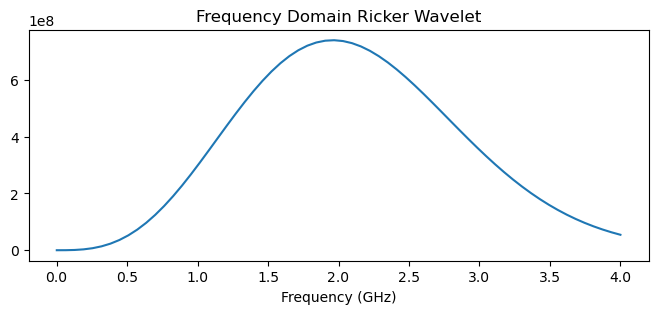

In [3]:
# Transmitter signal is a ricker wavelet, here defined in the frequency domain

central_freq = 1.6e9
max_f = 4e9
num_points = 2**6 
freq_range = np.linspace(1e6, max_f, num=num_points)
ricker = (2/(np.sqrt(np.pi))) * ((freq_range**3 ) / central_freq**2) * np.exp(-(freq_range **2) / (central_freq **2))


fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(freq_range/1e9,ricker)
ax.set_xlabel('Frequency (GHz)')
ax.set_title('Frequency Domain Ricker Wavelet')

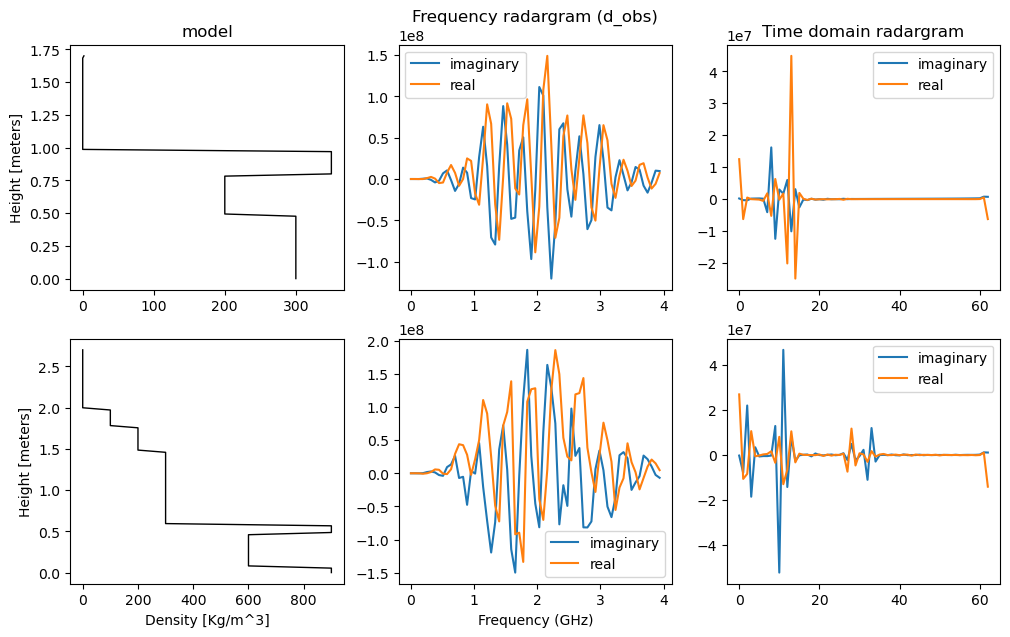

In [4]:
# synthetic data is computed from a density/depth model

colors = plt.cm.jet(np.linspace(0,1,22))
def plot_m(m,color_ix=1):
    n_cells = 100
    x_nodes = np.linspace(0, np.sum(m[2]), n_cells+1)
    dens_d = np.linspace(0, np.sum(m[2]), n_cells+1)
    for i in range(len(m[0])):
        dens_d[int((np.cumsum(m[2])[i] - (m[2])[i]) / (np.sum(m[2])/100)) : (int(np.cumsum(m[2])[i] / (np.sum(m[2])/100)))+1 ] = m[0][i]       
    #plt.plot(dens_d,color=colors[color_ix])
    return dens_d, x_nodes

# sample model parameters
layer_depths = np.array([.1,.4,.1,.9,.3,.2,.7]) # ex1 uses .3m depth for all layers
layer_density = np.array([900,600,900,300,200,100,0]) # random btw 50 - 900 kg/m3

m_true = np.array([layer_density,np.zeros(len(layer_density)),layer_depths]) # sample true model
m_true_flat = m_true.reshape(1,-1)[0] # flattened for compatibility with sp.optimize.minimize

#alternitive simple model
layer_depths1 = np.array([.5,.3,.2,.7]) # ex1 uses .3m depth for all layers
layer_density1 = np.array([300,200,350,0]) # random btw 50 - 900 kg/m3
m_true1 = np.array([layer_density1,np.zeros(len(layer_density1)),layer_depths1]) # sample true model
m_true_flat1 = m_true1.reshape(1,-1)[0] 

fig, ax = plt.subplots(2, 3, figsize=(12, 7))

ax[0,0].plot(plot_m(m_true1)[0],plot_m(m_true1)[1], label = "True Model", color = "k", linewidth = 1)

ax[0,0].set_title("model")
ax[0,0].set_ylabel("Height [meters]")

radargram1 = Radargram_from_model(m_true_flat1)
ax[0,1].plot(freq_range[:-1]/1e9,radargram1.imag, label = "imaginary")
ax[0,1].plot(freq_range[:-1]/1e9,radargram1.real, label = "real")

ax[0,1].set_title("Frequency radargram (d_obs)")
ax[0,1].legend()

td_radargram1 = np.fft.ifft(radargram1)
ax[0,2].plot(td_radargram1.imag, label = "imaginary")
ax[0,2].plot(td_radargram1.real, label = "real")

ax[0,2].set_title("Time domain radargram")
ax[0,2].legend()

ax[1,0].plot(plot_m(m_true)[0],plot_m(m_true)[1], label = "True Model", color = "k", linewidth = 1)

ax[1,0].set_xlabel("Density [Kg/m^3]")
ax[1,0].set_ylabel("Height [meters]")

radargram = Radargram_from_model(m_true_flat)
ax[1,1].plot(freq_range[:-1]/1e9,radargram.imag, label = "imaginary")
ax[1,1].plot(freq_range[:-1]/1e9,radargram.real, label = "real")

ax[1,1].set_xlabel('Frequency (GHz)')
ax[1,1].legend()

td_radargram = np.fft.ifft(radargram)
ax[1,2].plot(td_radargram.imag, label = "imaginary")
ax[1,2].plot(td_radargram.real, label = "real")

ax[1,2].legend()





#### although the inversions are preformed in the frequency domain, visually identifing spikes in the time domain data may be useful in estimating an initial reference model.

# Inverse modeling
### minimizing the data misfit as r = $\sum$ (Dobs - Dpred)^2

In [5]:
def min_L2(m_ref_flat):

    return np.sum((Radargram_from_model(m_true_flat_A).real-Radargram_from_model(m_ref_flat).real)**2)

In [6]:
# to help avoid local minima in the misfit function it is useful to start the inversion with lower frequencies and 
# using the result as a reference model and repeating the inversion with more frequencies until the full frequency range is used
freq_steps = np.arange(2e8,4e9+1,2e8)
freq_step_ix = np.round(np.linspace(0,num_points-1,20)).astype(int)



In [7]:
# define a reference model # here is a 3 layer example
# ref_dep = np.array([.1,.5,.1,1.0,.2,.3,.3]) # ex1 uses .3m depth for all layers
# ref_den = np.array([500,500,800,250,250,50,0]) # random btw 50 - 900 kg/m3
ref_dep1 = np.array([.4,.3,.3,.3]) # ex1 uses .3m depth for all layers
ref_den1 = np.array([250,250,250,0]) # random btw 50 - 900 kg/m3
m_ref1 = np.array([ref_den1,np.zeros(len(ref_den1)),ref_dep1])
m_ref_flat1 = m_ref1.reshape(1,-1)[0]
num_layers = len(m_ref1[0])

layer_depths1 = np.array([.5,.3,.2,.7]) # ex1 uses .3m depth for all layers
layer_density1 = np.array([300,200,350,0]) # random btw 50 - 900 kg/m3
m_true1 = np.array([layer_density1,np.zeros(len(layer_density1)),layer_depths1]) # sample true model
m_true_flat1 = m_true1.reshape(1,-1)[0] 

# bounds based on possible values for snow density and layer thickness
bounds = [(0, 917)]*(num_layers-1) + [(0,0)] + [(0, 0)]*num_layers + [(0, 6)]*(num_layers-1) + [(.3,.3)]

m_true_flat_A = m_true_flat1
mpred_evo_3lay = np.zeros((len(freq_steps), len(m_ref_flat1)))
for i, ix in enumerate(freq_step_ix):
    max_f = freq_steps[i]
    if i == 0:
        mref_itr = minimize(min_L2, m_ref_flat1,method='Nelder-Mead',bounds = bounds, options={'xatol': 1, 'disp': True}).x
    else:
        mref_itr = minimize(min_L2, mref_itr,method='Nelder-Mead',bounds = bounds, options={'xatol': 1, 'disp': True}).x
        
    mpred_evo_3lay[i] = mref_itr

Optimization terminated successfully.
         Current function value: 0.000113
         Iterations: 301
         Function evaluations: 531
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 1465
         Function evaluations: 2141
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 405
         Function evaluations: 674
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 243
         Function evaluations: 429
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 171
         Function evaluations: 333
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 169
         Function evaluations: 333
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 163
         Function evaluations: 324
Optimization termi

In [22]:

ref_dep = np.array([.4,.1,.9,.3,.2,.3]) # ex1 uses .3m depth for all layers
ref_den = np.array([300,600,400,300,200,0]) # random btw 50 - 900 kg/m3
m_ref = np.array([ref_den,np.zeros(len(ref_den)),ref_dep])
m_ref_flat = m_ref.reshape(1,-1)[0]
num_layers = len(m_ref[0])
layer_depths = np.array([.4,.1,.9,.3,.2,.3]) # ex1 uses .3m depth for all layers
layer_density = np.array([200,700,300,200,100,0]) # random btw 50 - 900 kg/m3
m_true = np.array([layer_density,np.zeros(len(layer_density)),layer_depths]) # sample true model
m_true_flat = m_true.reshape(1,-1)[0] # flattened for compatibility with sp.optimize.minimize
bounds = [(0, 917)]*(num_layers-1) + [(0,0)] + [(0, 0)]*num_layers + [(0, 6)]*(num_layers-1) + [(.3,.3)]

m_true_flat_A = m_true_flat
mpred_evo_6lay = np.zeros((len(freq_steps), len(m_ref_flat)))
for i, ix in enumerate(freq_step_ix):
    max_f = freq_steps[i]
    if i == 0:
        mref_itr = minimize(min_L2, m_ref_flat,method='Nelder-Mead',bounds = bounds, options={'xatol': 1, 'disp': True}).x
    else:
        mref_itr = minimize(min_L2, mref_itr,method='Nelder-Mead',bounds = bounds, options={'xatol': 1, 'disp': True}).x
        
    mpred_evo_6lay[i] = mref_itr

Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 542
         Function evaluations: 938


C:\Users\jdavo\AppData\Local\Temp\ipykernel_21124\3970268172.py:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  mref_itr = minimize(min_L2, mref_itr,method='Nelder-Mead',bounds = bounds, options={'xatol': 1, 'disp': True}).x


Optimization terminated successfully.
         Current function value: 10220394669423978.000000
         Iterations: 1631
         Function evaluations: 2829
Optimization terminated successfully.
         Current function value: 10813298215871694.000000
         Iterations: 1402
         Function evaluations: 2536
Optimization terminated successfully.
         Current function value: 10827631942321180.000000
         Iterations: 1242
         Function evaluations: 2371


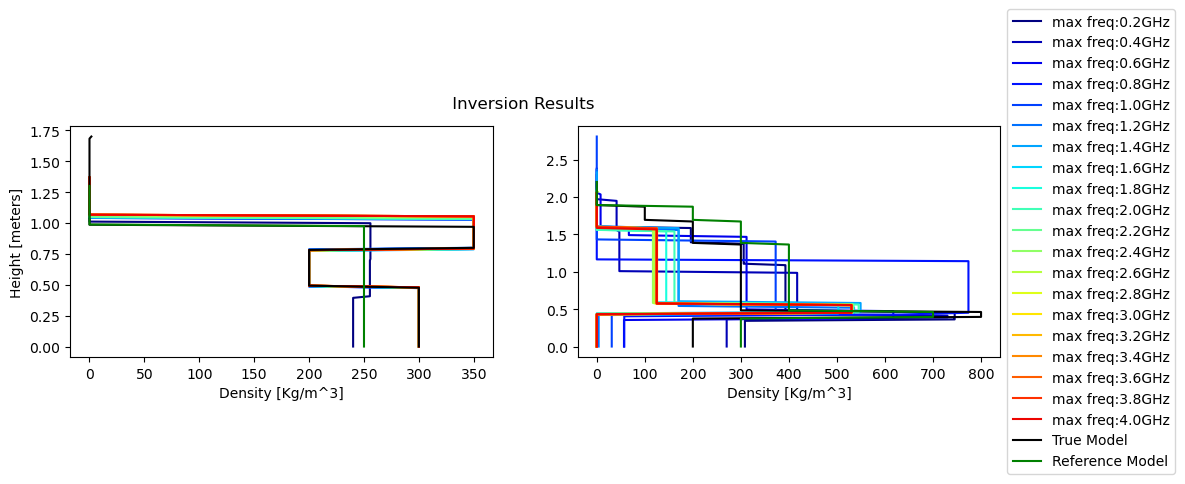

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
fig.suptitle(' Inversion Results')

for i in range(len(freq_step_ix)):
    
    ax[0].plot(plot_m(mpred_evo_3lay[i].reshape(3,-1))[0],plot_m(mpred_evo_3lay[i].reshape(3,-1))[1], color = colors[i], label = f"max freq:{(i+1)*2e-1:.1f}GHz")
    
ax[0].plot(plot_m(m_true_flat1.reshape(3,-1))[0],plot_m(m_true_flat1.reshape(3,-1))[1], label = "True Model", color = "k")#, linewidth = 4)
ax[0].plot(plot_m(m_ref_flat1.reshape(3,-1))[0],plot_m(m_ref_flat1.reshape(3,-1))[1], label = "Reference Model", color = "g")

ax[0].set_ylabel("Height [meters]")
ax[0].set_xlabel("Density [Kg/m^3]")

for i in range(len(freq_step_ix)):
    
    ax[1].plot(plot_m(mpred_evo_6lay[i].reshape(3,-1))[0],plot_m(mpred_evo_6lay[i].reshape(3,-1))[1], color = colors[i], label = f"max freq:{(i+1)*2e-1:.1f}GHz")
    
ax[1].plot(plot_m(m_true_flat.reshape(3,-1))[0],plot_m(m_true_flat.reshape(3,-1))[1], label = "True Model", color = "k")#, linewidth = 4)
ax[1].plot(plot_m(m_ref_flat.reshape(3,-1))[0],plot_m(m_ref_flat.reshape(3,-1))[1], label = "Reference Model", color = "g")

ax[1].set_xlabel("Density [Kg/m^3]")


ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### with these two examples we can see that the 3 layer model (left) converges even with a homogeneous reference model, the more complicated model only converges with a highly accurite reference model

#### by weighting my optimization i hope to improve the preformance